In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

### 내가 디자인한 물질

In [41]:
mycpds = {'test01':'O=C1CC(CN1C2CCCCC2)C(N)=O', 
          'test02':'CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O'}

In [42]:
mycpds_names = list(mycpds.keys())
mycpds_smiles = list(mycpds.values())
mycpds_mols = [Chem.MolFromSmiles(x) for x in mycpds_smiles]
mycpds_fps = [Chem.RDKFingerprint(x) for x in mycpds_mols]

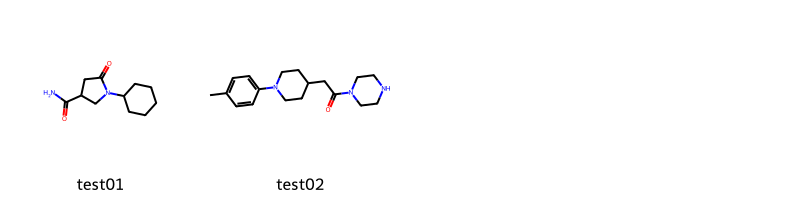

In [43]:
img = Draw.MolsToGridImage(mycpds_mols, molsPerRow=4, subImgSize=(200, 200), legends=mycpds_names)
img

### 비교할 물질들이 담긴 SDF 파일

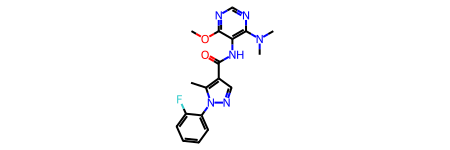

In [44]:
# 비교 레퍼런스
library = 'samples.sdf'
supplier = Chem.SDMolSupplier(library)
supplier[0]

In [45]:
# 이름 컬럼 지정 
name_col = 'Catalog ID'

In [46]:
libcpds_names = [x.GetProp(name_col) for x in supplier]
libcpds_mols = [x for x in supplier if x is not None]
libcpds_smiles = [Chem.MolToSmiles(x) for x in libcpds_mols]
libcpds_fps = [Chem.RDKFingerprint(x) for x in libcpds_mols]

is_null = lib.isnull().any()
print("[null cells]")
print(is_null)
print("molecules: ", lib.shape)

[null cells]
name      False
mols      False
smiles    False
fpsub     False
query     False
dtype: bool
molecules:  (5440, 5)


### Similarity 검색

In [47]:
my = pd.DataFrame({'name':mycpds_names, 'mols':mycpds_mols, 'smiles':mycpds_smiles, 'fpsim':1, 'query':mycpds_names})
my

,name,mols,smiles,fpsim,query
0,test01,<rdkit.Chem.rdchem.Mol object at 0x7f38396ecf90>,O=C1CC(CN1C2CCCCC2)C(N)=O,1,test01
1,test02,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed0e0>,CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O,1,test02


In [48]:
lib = pd.DataFrame({'name':libcpds_names, 'mols':libcpds_mols, 'smiles':libcpds_smiles, 'fpsim':None, 'query':None}) 
lib

,name,mols,smiles,fpsim,query
0,Z1379390999,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed230>,COc1ncnc(N(C)C)c1NC(=O)c1cnn(-c2ccccc2F)c1C,None,None
1,Z1391763801,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed380>,O=C(Nc1cnn(-c2ccccc2F)c1)c1cccc(F)c1Cl,None,None
2,Z460990036,<rdkit.Chem.rdchem.Mol object at 0x7f38325122d0>,CCN(C(=O)c1csc(-c2cnn(C)c2)n1)c1ccccc1C,None,None
3,Z284650430,<rdkit.Chem.rdchem.Mol object at 0x7f3832512ab0>,COC(=O)c1cc(NC(=O)c2sc(-c3ccccn3)nc2C)c(F)cc1F,None,None
4,Z1465772343,<rdkit.Chem.rdchem.Mol object at 0x7f3832512260>,Cc1c(C(=O)N2CCc3ccc(F)cc3C2)nnn1-c1cccc2ncccc12,None,None
...,...,...,...,...,...
5435,Z1798534420,<rdkit.Chem.rdchem.Mol object at 0x7f38323f0270>,CC1CCN(C(=O)Nc2cc(-c3ccccc3)nn2C(C)C)C1CO,None,None
5436,Z1413707898,<rdkit.Chem.rdchem.Mol object at 0x7f38323f02e0>,Cc1nc(CNc2ccccc2CS(C)(=O)=O)oc1-c1ccc(Cl)cc1,None,None
5437,Z27541874,<rdkit.Chem.rdchem.Mol object at 0x7f38323f0350>,CCOc1ccc(C(=O)NCc2ccc3c(c2)OCCO3)cc1OCC,None,None
5438,Z1895481206,<rdkit.Chem.rdchem.Mol object at 0x7f38323f03c0>,CCn1c(-c2ccccn2)nnc1S(=O)(=O)Cc1ccc(F)cc1,None,None


In [49]:
from rdkit import Chem, DataStructs
for fp, name in zip(mycpds_fps, mycpds_names):
    lib['query'] = name   # 추후 sort에 필요
    sim = DataStructs.BulkTanimotoSimilarity(fp, libcpds_fps)   # 유사도 계산
    lib['fpsim'] = sim   # 데이터프레임에 유사도 추가
    searched = lib.sort_values('fpsim', ascending=False)   # 정렬
    searched = searched[:5]   # 상위 5개만 선택
    my = pd.concat([my, searched])   # 내 물질이 있는 데이터프레임에 추가

In [50]:
my.sort_values('query', inplace=True)   # query 컬럼으로 정렬
my.reset_index(drop=True, inplace=True)   # 인덱스 재설정
my['fpsim'] = my['fpsim'].round(2)
my

,name,mols,smiles,fpsim,query
0,test01,<rdkit.Chem.rdchem.Mol object at 0x7f38396ecf90>,O=C1CC(CN1C2CCCCC2)C(N)=O,1.00,test01
1,Z1161165474,<rdkit.Chem.rdchem.Mol object at 0x7f383257eab0>,CCC1CCCN(C(=O)C2CC(=O)N(C3CCC(C)CC3)C2)C1,0.85,test01
2,Z1160974863,<rdkit.Chem.rdchem.Mol object at 0x7f383256ea40>,CC1CCC(N2CC(C(=O)NC3(C)CCCCC3)CC2=O)CC1,0.83,test01
3,Z1190654290,<rdkit.Chem.rdchem.Mol object at 0x7f38323e00b0>,CC1CCC(NC(=O)C2CC(=O)N(C3CCCC3)C2)C(C)C1,0.83,test01
4,Z363389668,<rdkit.Chem.rdchem.Mol object at 0x7f383257d150>,O=C1CC(C(=O)N2CCN(Cc3ccncc3)CC2)CN1CC1CC1,0.51,test01
5,Z1895250616,<rdkit.Chem.rdchem.Mol object at 0x7f38325a3370>,O=C([C@@H]1C[C@H]1C(=O)N1CCN2CCCC2C1)N1CCN2CCC...,0.48,test01
6,test02,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed0e0>,CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O,1.00,test02
7,Z1159140025,<rdkit.Chem.rdchem.Mol object at 0x7f38323d0200>,CCN1CCN(C(=O)CC2CCN(c3ccc(C#N)cc3)CC2)CC1,0.93,test02
8,Z1437571604,<rdkit.Chem.rdchem.Mol object at 0x7f38323b1a10>,CC(C)C(=O)N1CCC(NC2CCN(c3ccccc3)CC2)CC1,0.53,test02
9,Z26850208,<rdkit.Chem.rdchem.Mol object at 0x7f383256e810>,Cc1cccc(N2CCN(C(=O)C3CCC3)CC2)c1C,0.51,test02


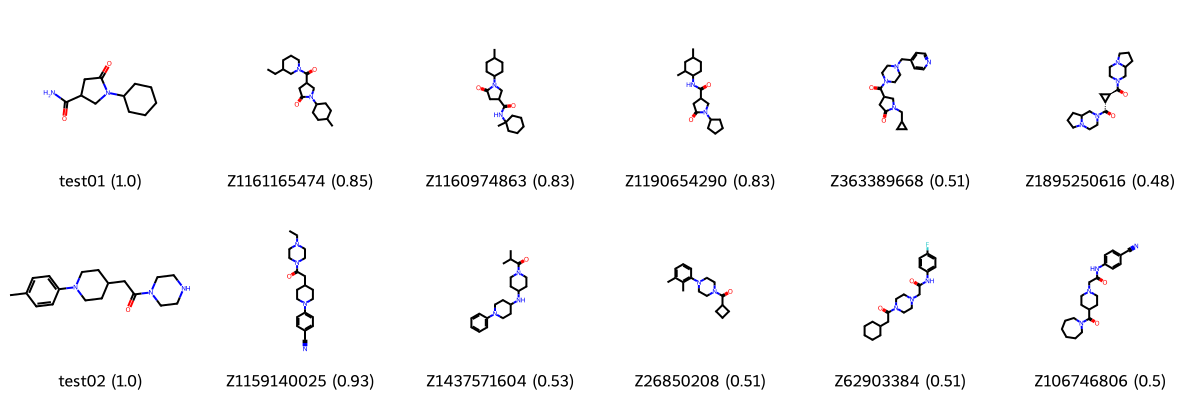

In [51]:
from rdkit.Chem import Draw

# 'name' 컬럼과 'fpsim' 컬럼의 값을 연결하여 리스트 생성
legends = [f"{n} ({f})" for n, f in zip(my['name'], my['fpsim'])]

# 'mols' 컬럼에 있는 화학 구조들을 그리드 이미지로 보여주기
img = Draw.MolsToGridImage(my['mols'], molsPerRow=6, subImgSize=(200,200), legends=legends, useSVG=True)

img

In [52]:
my

,name,mols,smiles,fpsim,query
0,test01,<rdkit.Chem.rdchem.Mol object at 0x7f38396ecf90>,O=C1CC(CN1C2CCCCC2)C(N)=O,1.00,test01
1,Z1161165474,<rdkit.Chem.rdchem.Mol object at 0x7f383257eab0>,CCC1CCCN(C(=O)C2CC(=O)N(C3CCC(C)CC3)C2)C1,0.85,test01
2,Z1160974863,<rdkit.Chem.rdchem.Mol object at 0x7f383256ea40>,CC1CCC(N2CC(C(=O)NC3(C)CCCCC3)CC2=O)CC1,0.83,test01
3,Z1190654290,<rdkit.Chem.rdchem.Mol object at 0x7f38323e00b0>,CC1CCC(NC(=O)C2CC(=O)N(C3CCCC3)C2)C(C)C1,0.83,test01
4,Z363389668,<rdkit.Chem.rdchem.Mol object at 0x7f383257d150>,O=C1CC(C(=O)N2CCN(Cc3ccncc3)CC2)CN1CC1CC1,0.51,test01
5,Z1895250616,<rdkit.Chem.rdchem.Mol object at 0x7f38325a3370>,O=C([C@@H]1C[C@H]1C(=O)N1CCN2CCCC2C1)N1CCN2CCC...,0.48,test01
6,test02,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed0e0>,CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O,1.00,test02
7,Z1159140025,<rdkit.Chem.rdchem.Mol object at 0x7f38323d0200>,CCN1CCN(C(=O)CC2CCN(c3ccc(C#N)cc3)CC2)CC1,0.93,test02
8,Z1437571604,<rdkit.Chem.rdchem.Mol object at 0x7f38323b1a10>,CC(C)C(=O)N1CCC(NC2CCN(c3ccccc3)CC2)CC1,0.53,test02
9,Z26850208,<rdkit.Chem.rdchem.Mol object at 0x7f383256e810>,Cc1cccc(N2CCN(C(=O)C3CCC3)CC2)c1C,0.51,test02


In [53]:
# 각 쿼리에 대한 similarity search 결과를 파일로 저장
Save = False
cutoff = 0.7

from rdkit.Chem import PandasTools
if Save:
    PandasTools.WriteSDF(my, 'res_similar_cpds.sdf', molColName='mols', properties=list(my.columns))

### Substructure 검색

In [54]:
my = pd.DataFrame({'name':mycpds_names, 'mols':mycpds_mols, 'smiles':mycpds_smiles, 'fpsub':True, 'query':mycpds_names})
my

,name,mols,smiles,fpsub,query
0,test01,<rdkit.Chem.rdchem.Mol object at 0x7f38396ecf90>,O=C1CC(CN1C2CCCCC2)C(N)=O,True,test01
1,test02,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed0e0>,CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O,True,test02


In [55]:
lib = pd.DataFrame({'name':libcpds_names, 'mols':libcpds_mols, 'smiles':libcpds_smiles, 'fpsub':False, 'query':None}) 
lib

,name,mols,smiles,fpsub,query
0,Z1379390999,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed230>,COc1ncnc(N(C)C)c1NC(=O)c1cnn(-c2ccccc2F)c1C,False,None
1,Z1391763801,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed380>,O=C(Nc1cnn(-c2ccccc2F)c1)c1cccc(F)c1Cl,False,None
2,Z460990036,<rdkit.Chem.rdchem.Mol object at 0x7f38325122d0>,CCN(C(=O)c1csc(-c2cnn(C)c2)n1)c1ccccc1C,False,None
3,Z284650430,<rdkit.Chem.rdchem.Mol object at 0x7f3832512ab0>,COC(=O)c1cc(NC(=O)c2sc(-c3ccccn3)nc2C)c(F)cc1F,False,None
4,Z1465772343,<rdkit.Chem.rdchem.Mol object at 0x7f3832512260>,Cc1c(C(=O)N2CCc3ccc(F)cc3C2)nnn1-c1cccc2ncccc12,False,None
...,...,...,...,...,...
5435,Z1798534420,<rdkit.Chem.rdchem.Mol object at 0x7f38323f0270>,CC1CCN(C(=O)Nc2cc(-c3ccccc3)nn2C(C)C)C1CO,False,None
5436,Z1413707898,<rdkit.Chem.rdchem.Mol object at 0x7f38323f02e0>,Cc1nc(CNc2ccccc2CS(C)(=O)=O)oc1-c1ccc(Cl)cc1,False,None
5437,Z27541874,<rdkit.Chem.rdchem.Mol object at 0x7f38323f0350>,CCOc1ccc(C(=O)NCc2ccc3c(c2)OCCO3)cc1OCC,False,None
5438,Z1895481206,<rdkit.Chem.rdchem.Mol object at 0x7f38323f03c0>,CCn1c(-c2ccccn2)nnc1S(=O)(=O)Cc1ccc(F)cc1,False,None


In [56]:
from rdkit import Chem, DataStructs
for mol, name in zip(mycpds_mols, mycpds_names):
    lib['query'] = name   # 추후 sort에 필요
    matched = lib['mols'].apply(lambda x: x.HasSubstructMatch(mol))
    lib['fpsub'] = matched   # 데이터프레임에 유사도 추가
    searched = lib.loc[lib['fpsub'] == True]   # 정렬
    my = pd.concat([my, searched])   # 내 물질이 있는 데이터프레임에 추가

In [57]:
my.sort_values('query', inplace=True)   # query 컬럼으로 정렬
my.reset_index(drop=True, inplace=True)   # 인덱스 재설정
my

,name,mols,smiles,fpsub,query
0,test01,<rdkit.Chem.rdchem.Mol object at 0x7f38396ecf90>,O=C1CC(CN1C2CCCCC2)C(N)=O,True,test01
1,Z1160974863,<rdkit.Chem.rdchem.Mol object at 0x7f383256ea40>,CC1CCC(N2CC(C(=O)NC3(C)CCCCC3)CC2=O)CC1,True,test01
2,Z1161165474,<rdkit.Chem.rdchem.Mol object at 0x7f383257eab0>,CCC1CCCN(C(=O)C2CC(=O)N(C3CCC(C)CC3)C2)C1,True,test01
3,test02,<rdkit.Chem.rdchem.Mol object at 0x7f38396ed0e0>,CC1=CC=C(C=C1)N2CCC(CC2)CC(N3CCNCC3)=O,True,test02
4,Z1159140025,<rdkit.Chem.rdchem.Mol object at 0x7f38323d0200>,CCN1CCN(C(=O)CC2CCN(c3ccc(C#N)cc3)CC2)CC1,True,test02


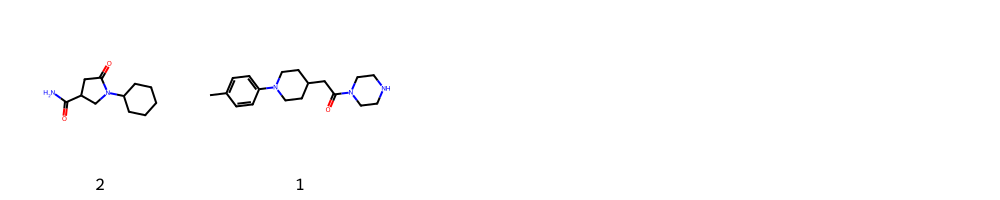

In [58]:
groupby = my.groupby('query')
uniq_count = groupby.count().reset_index().name.tolist()
uniq_count = [str(x-1) for x in uniq_count]
unique_mols = groupby.first()['mols'].tolist()

img = Draw.MolsToGridImage(unique_mols, molsPerRow=5, subImgSize=(200,200), legends=uniq_count, useSVG=True)
img

In [60]:
# 각 쿼리에 대한 substrucutre match 결과를 파일로 저장
Save = False

from rdkit.Chem import PandasTools
if Save:
    for query in my['query'].unique():
        group = my.loc[my['query'] == query]
        PandasTools.WriteSDF(group, f"res_matched_{query}.sdf", molColName='mols', properties=list(my.columns))